## Construction Defects Classifications Using Neural Networks

This project proposes a system which uses a convolutional neural network and detects defects in construction sites. The neural network is deployed on Amazon Web Service as an Application Programming Interface API. The API will equip single image processing and batch processing of images. The project will automate the defect detection process and improve critical metrics like cost and safety during construction.


## Dataset Description
Source: Dataset was taken from the paper BD3: Building Defects Detection Dataset for Benchmarking Computer Vision Techniques for Automated Defect Identification link


| Defect Name | Description | Number of Images |
|-------------|-------------|------------------|
| Algae | Fungi resembling green, brown, or black patches or slime on the surface | 624 |
| Major Crack | Cracks with visible gaps | 620 |
| Minor Crack | Cracks without visible gaps | 580 |
| Peeling | Loss of the outer covering of paint | 520 |
| Spalling | Surface break exposing inner material | 500 |
| Stain | Visible man-made or natural color marks | 521 |
| Normal | Clean walls with no visible signs of defects | 600 |

## **SET UP + IMPORT**

In [1]:

# Importing the libraries

import os, zipfile
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
#UNZIP
# Path to your uploaded zip
zip_path = "curated-dataset.zip"

extract_dir = "/dataset"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

!ls -R /content/dataset

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
DATA_DIR = "/dataset/curated-dataset"
IMAGE_SIZE = (128, 128)      # smaller than 224 to keep it lightweight
BATCH_SIZE = 32
NUM_CLASSES = 7


## **Data generators (with and without augmentation)**

In [4]:
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_datagen_noaug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen_aug = train_datagen_aug.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

train_gen_noaug = train_datagen_noaug.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print("Class indices:", train_gen_aug.class_indices)


Found 3173 images belonging to 7 classes.
Found 3173 images belonging to 7 classes.
Found 792 images belonging to 7 classes.
Class indices: {'algae': 0, 'major_crack': 1, 'minor_crack': 2, 'normal': 3, 'peeling': 4, 'spalling': 5, 'stain': 6}


## **Baseline model: MLP (no convolutions)**

In [5]:
def build_mlp(input_shape=(128,128,3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

mlp_model = build_mlp()
mlp_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_mlp = mlp_model.fit(
    train_gen_noaug,
    epochs=10,
    validation_data=val_gen
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 915ms/step - accuracy: 0.1409 - loss: 6.7456 - val_accuracy: 0.1515 - val_loss: 1.9450
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 333ms/step - accuracy: 0.1484 - loss: 1.9736 - val_accuracy: 0.1515 - val_loss: 1.9439
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 327ms/step - accuracy: 0.1532 - loss: 1.9440 - val_accuracy: 0.1566 - val_loss: 1.9434
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.1469 - loss: 1.9436 - val_accuracy: 0.1566 - val_loss: 1.9430
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.1497 - loss: 1.9431 - val_accuracy: 0.1566 - val_loss: 1.9427
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 338ms/step - accuracy: 0.1529 - loss: 1.9429 - val_accuracy: 0.1566 - val_loss: 1.9427
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 346ms/step - accuracy: 0.1573 - loss: 1.9425 - val_accuracy: 0.1566 - val_loss: 1.9425
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 340ms/step - accuracy: 0.1623 - loss: 1.94

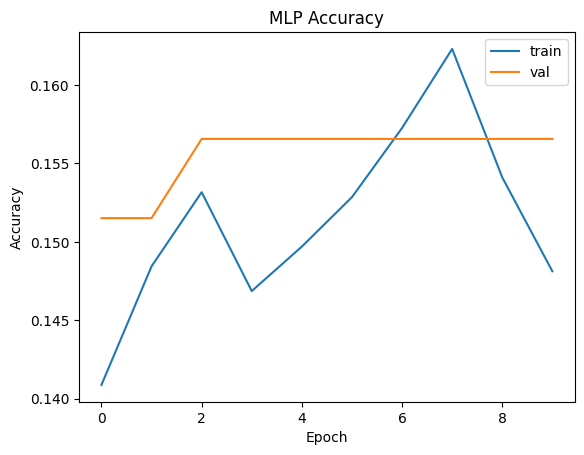

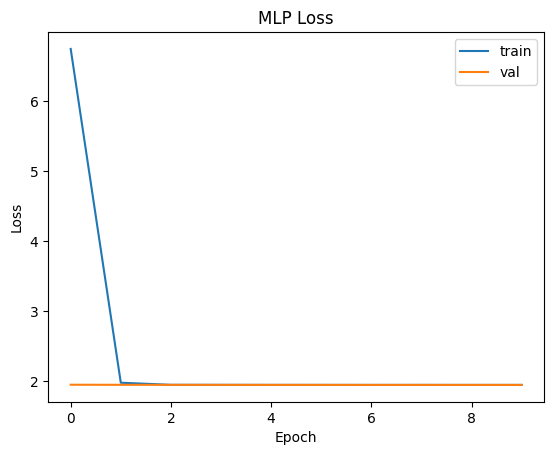

In [6]:
def plot_history(history, title_prefix=""):
    plt.figure()
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.show()

plot_history(history_mlp, "MLP")


## **Our main CNN architecture (from scratch)**

In [7]:
def build_cnn(input_shape=(128,128,3), num_classes=NUM_CLASSES):
    model = tf.keras.models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

## **CNN + Adam + augmentation**

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 361ms/step - accuracy: 0.2332 - loss: 1.8625 - val_accuracy: 0.2765 - val_loss: 1.7213
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 567ms/step - accuracy: 0.3133 - loss: 1.6796 - val_accuracy: 0.3384 - val_loss: 1.5289
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 568ms/step - accuracy: 0.3520 - loss: 1.5692 - val_accuracy: 0.3636 - val_loss: 1.4645
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 429ms/step - accuracy: 0.3924 - loss: 1.4732 - val_accuracy: 0.4053 - val_loss: 1.4451
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.4201 - loss: 1.4481 - val_accuracy: 0.4798 - val_loss: 1.3505
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 380ms/step - accuracy: 0.4523 - loss: 1.3957 - val_accuracy: 0.4899 - val_loss: 1.2746
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 65s 652ms/step - accuracy: 0.4882 - loss: 1.3195 - val_accuracy: 0.5644 - val_loss: 1.2641
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 655ms/step - accuracy: 0.5102 - loss: 1

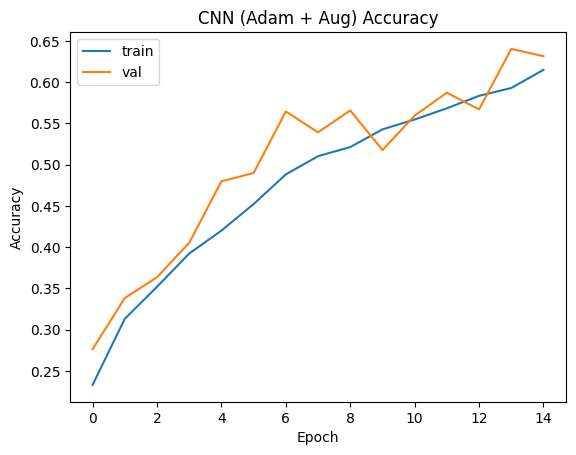

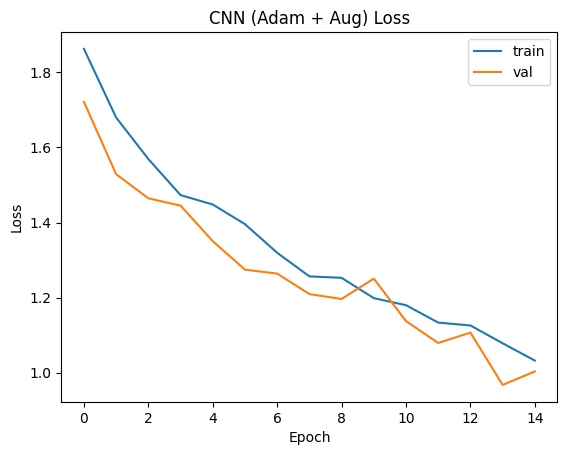

In [8]:
cnn_adam = build_cnn()
cnn_adam.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn_adam = cnn_adam.fit(
    train_gen_aug,
    epochs=15,
    validation_data=val_gen
)

plot_history(history_cnn_adam, "CNN (Adam + Aug)")


## CNN + SGD + **augmentation**

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 517ms/step - accuracy: 0.1746 - loss: 1.9344 - val_accuracy: 0.2513 - val_loss: 1.8638
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 323ms/step - accuracy: 0.2052 - loss: 1.9050 - val_accuracy: 0.2866 - val_loss: 1.7711
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 625ms/step - accuracy: 0.2685 - loss: 1.7783 - val_accuracy: 0.3371 - val_loss: 1.6140
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 585ms/step - accuracy: 0.3158 - loss: 1.6684 - val_accuracy: 0.3523 - val_loss: 1.5380
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 591ms/step - accuracy: 0.3539 - loss: 1.5835 - val_accuracy: 0.3674 - val_loss: 1.5281
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 616ms/step - accuracy: 0.3876 - loss: 1.5111 - val_accuracy: 0.4381 - val_loss: 1.4214
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 619ms/step - accuracy: 0.4192 - loss: 1.4481 - val_accuracy: 0.4735 - val_loss: 1.3997
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 61s 608ms/step - accuracy: 0.4280 - loss: 1

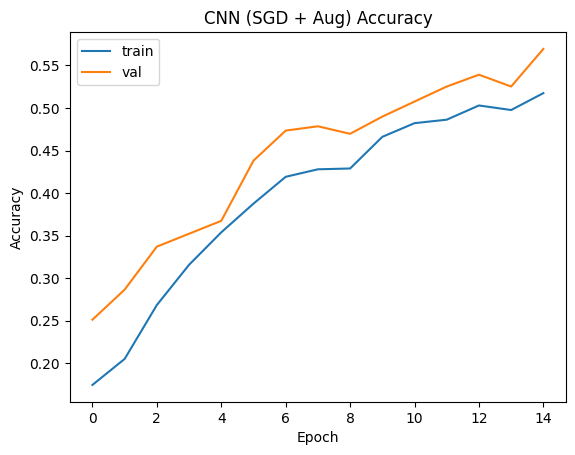

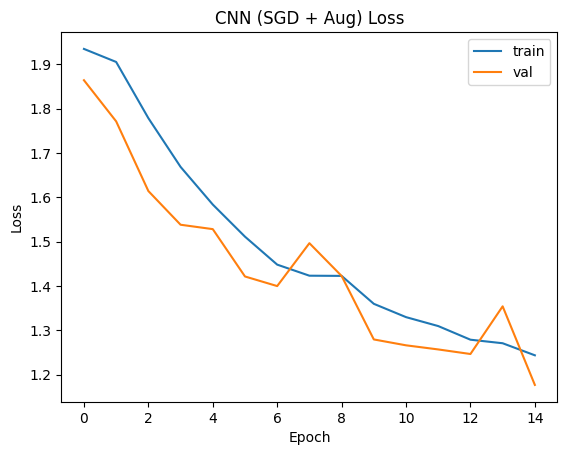

In [9]:
cnn_sgd = build_cnn()
cnn_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn_sgd = cnn_sgd.fit(
    train_gen_aug,
    epochs=15,
    validation_data=val_gen
)

plot_history(history_cnn_sgd, "CNN (SGD + Aug)")


### **evaluation**

In [10]:
# Evaluate best model
best_model = cnn_adam

val_loss, val_acc = best_model.evaluate(val_gen, verbose=0)
print("Validation accuracy:", val_acc)

# Get predictions for classification report
val_gen.reset()
pred_probs = best_model.predict(val_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes

print(classification_report(
    y_true,
    y_pred,
    target_names=list(val_gen.class_indices.keys())
))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)




Validation accuracy: 0.631313145160675
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step
              precision    recall  f1-score   support

       algae       0.70      0.86      0.78       124
 major_crack       0.67      0.59      0.62       116
 minor_crack       0.57      0.52      0.54       124
      normal       0.69      0.97      0.81       120
     peeling       0.52      0.49      0.50       104
    spalling       0.56      0.68      0.62       100
       stain       0.65      0.25      0.36       104

    accuracy                           0.63       792
   macro avg       0.62      0.62      0.60       792
weighted avg       0.63      0.63      0.61       792

Confusion matrix:
 [[107   0   0   1   4  12   0]
 [  8  68  18   5   5   8   4]
 [  0  17  64  33   6   0   4]
 [  0   0   2 116   1   1   0]
 [  5   4  17   5  51  18   4]
 [ 24   1   0   0   5  68   2]
 [  8  12  11   7  26  14  26]]


In [11]:
models = {
    "MLP baseline": mlp_model,
    "CNN_SGD": cnn_sgd,
    "CNN_Adam": cnn_adam
}

for name, m in models.items():
    loss, acc = m.evaluate(val_gen, verbose=0)
    print(name, "val_acc =", acc, "val_loss =", loss)


MLP baseline val_acc = 0.15656565129756927 val_loss = 1.9424000978469849
CNN_SGD val_acc = 0.5694444179534912 val_loss = 1.1768772602081299
CNN_Adam val_acc = 0.631313145160675 val_loss = 1.0035120248794556


cnn without augmentation

In [12]:
from tensorflow.keras import models, layers

def build_cnn(input_shape=(128,128,3), num_classes=7):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model


In [13]:
cnn_no_aug = build_cnn()


In [14]:
print(models)


<module 'keras.models' from 'c:\\Users\\apoor\\projects\\construction\\.venv\\Lib\\site-packages\\keras\\models\\__init__.py'>


case study

In [15]:
batch_x, batch_y = next(val_gen)
pred = best_model.predict(batch_x[0:1])
print("GT:", np.argmax(batch_y[0]),
      "Pred:", np.argmax(pred),
      "Conf:", np.max(pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
GT: 0 Pred: 0 Conf: 0.9998124


final

In [ ]:
# === FINAL MODEL EVALUATION + SAVE ARTIFACTS ===

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json

# 1. best model (CNN with Adam)
best_model = cnn_adam

print("=== BEST MODEL (CNN + Adam) ON VALIDATION SET ===")
val_loss, val_acc = best_model.evaluate(val_gen, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Validation loss: {val_loss:.4f}")

# 2. predictions for classification report + confusion matrix
val_gen.reset()
pred_probs = best_model.predict(val_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes

class_names = list(val_gen.class_indices.keys())

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("\n=== CONFUSION MATRIX ===")
print(cm)

# 3. Save model for API
best_model.save("model.keras")
print("\nSaved best model to model.keras")

# 4. Save label map for API
label_map = val_gen.class_indices   # same mapping as train_gen
with open("label_map.json", "w") as f:
    json.dump(label_map, f)

print("Saved label map to label_map.json")
print("\nDone. Artifacts ready for UI/API ")


=== BEST MODEL (CNN + Adam) ON VALIDATION SET ===
Validation accuracy: 0.6313
Validation loss: 1.0035
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       algae       0.70      0.86      0.78       124
 major_crack       0.67      0.59      0.62       116
 minor_crack       0.57      0.52      0.54       124
      normal       0.69      0.97      0.81       120
     peeling       0.52      0.49      0.50       104
    spalling       0.56      0.68      0.62       100
       stain       0.65      0.25      0.36       104

    accuracy                           0.63       792
   macro avg       0.62      0.62      0.60       792
weighted avg       0.63      0.63      0.61       792


=== CONFUSION MATRIX ===
[[107   0   0   1   4  12   0]
 [  8  68  18   5   5   8   4]
 [  0  17  64  33   6   0   4]
 [  0   0   2 116   1   1   0]
 [  5   4  17   5  51  18   4]
 [ 24   1   0   0   5  68   2]
 [  8  12  11   7

: 